In [ ]:
import pandas as pd
import numpy as np
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Paths for exported data, numpy arrays
DATA_PATH = os.path.join('dataset')
MRCNN_DATA_PATH = os.path.join('datasetmrcnn')

# Actions that we try to detect
actions = np.array(['Coffee', 'Cousin','Fast', 'Five', 'One','Thank You', 'Three','Two','Wrong','Yes'])

# Videos are going to be 30 frames in length
sequence_length = 60
label_map = {label: num for num, label in enumerate(actions)}

sequences, labels = [], []

# Load data from the "dataset" for training
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), f"{frame_num}.npy"))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

# Convert to numpy arrays
X = np.array(sequences)
y = to_categorical(labels).astype(int)

# Split the "dataset" data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize lists to hold MRCNN training and validation data
sequences_mrcnn_train, labels_mrcnn_train = [], []
sequences_mrcnn_val, labels_mrcnn_val = [], []

# Load data from the "datasetmrcnn" and prepare for training
for action in actions:
    sequences_mrcnn, labels_mrcnn = [], []
    dir_list = np.array(os.listdir(os.path.join(MRCNN_DATA_PATH, action))).astype(int)
    np.random.shuffle(dir_list)  # Shuffle to randomly select for train/test split
    # Calculate split index for 60/40 split
    split_index = int(len(dir_list) * 0.4)

    # Split the directories for training and validation
    train_dirs = dir_list[:split_index]
    val_dirs = dir_list[split_index:]

    
    for sequence in train_dirs:
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(MRCNN_DATA_PATH, action, str(sequence), f"{frame_num}.npy"))
            window.append(res)
        sequences_mrcnn_train.append(window)
        labels_mrcnn_train.append(label_map[action])
    
    for sequence in val_dirs:
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(MRCNN_DATA_PATH, action, str(sequence), f"{frame_num}.npy"))
            window.append(res)
        sequences_mrcnn_val.append(window)
        labels_mrcnn_val.append(label_map[action])

# Prepare MRCNN training and validation data
X_train_mrcnn = np.array(sequences_mrcnn_train)
y_train_mrcnn = to_categorical(np.array(labels_mrcnn_train), num_classes=len(actions))
X_val_mrcnn = np.array(sequences_mrcnn_val)
y_val_mrcnn = to_categorical(np.array(labels_mrcnn_val), num_classes=len(actions))

# Combine original and MRCNN training/validation data
X_train_combined = np.concatenate((X_train, X_train_mrcnn))
y_train_combined = np.concatenate((y_train, y_train_mrcnn))
X_val_combined = np.concatenate((X_val, X_val_mrcnn))
y_val_combined = np.concatenate((y_val, y_val_mrcnn))

# Updated Model architecture
model = Sequential()
model.add(LSTM(512, return_sequences=True, input_shape=(sequence_length, X.shape[2])))
model.add(BatchNormalization())  # Added BatchNormalization
model.add(Dropout(0.5))
model.add(LSTM(256, return_sequences=True))
model.add(BatchNormalization())  # Added BatchNormalization
model.add(Dropout(0.5))
model.add(LSTM(128))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(actions.shape[0], activation='softmax'))

# Compile the model with an initial learning rate
optimizer = Adam(learning_rate=0.001)  # Consider starting with a slightly higher learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Updated callbacks
log_dir = os.path.join('logs')
tensorboard_callback = TensorBoard(log_dir=log_dir)
early_stopping = EarlyStopping(monitor='val_loss', patience=20)  # Increased patience
model_checkpoint = ModelCheckpoint('best_model_10.h5', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001, verbose=1)  # New Callback

# Train the model using the combined dataset with an updated batch size
history = model.fit(X_train_combined, y_train_combined, epochs=500, batch_size=64,  # Adjusted batch size
                    validation_data=(X_val_combined, y_val_combined),
                    callbacks=[tensorboard_callback, early_stopping, model_checkpoint, reduce_lr])

# Save the model and weights
model.save('mrcnn_lstm_model_10C.h5')
model.save_weights('./mrcnn_lstm_weights_10C.h5')

print("Model and weights have been saved.")

# Generate predictions
y_pred = model.predict(X_val_combined)

# Convert one-hot encoded labels back to categorical labels
y_true = np.argmax(y_val_combined, axis=1)
y_pred = np.argmax(y_pred, axis=1)

# Generate and print classification report
class_names = ['Coffee', 'Cousin','Fast', 'Five', 'One','Thank You', 'Three','Two','Wrong','Yes']
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:")
print(report)

# Plotting the classification report
report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
precision = [report_dict[label]['precision'] for label in class_names]
recall = [report_dict[label]['recall'] for label in class_names]
f1_score = [report_dict[label]['f1-score'] for label in class_names]

x = range(len(class_names))

plt.figure(figsize=(10, 6))
plt.bar(x, precision, width=0.2, label='Precision')
plt.bar([i + 0.2 for i in x], recall, width=0.2, label='Recall')
plt.bar([i + 0.4 for i in x], f1_score, width=0.2, label='F1-score')

plt.xlabel('Class')
plt.ylabel('Score')
plt.title('Classification Report Metrics')
plt.xticks([i + 0.2 for i in x], class_names)
plt.legend()
plt.show()


Epoch 1/500
4/4 [==============================] - ETA: 0s - loss: 2.1989 - accuracy: 0.2083
Epoch 1: val_loss improved from inf to 2.27820, saving model to best_model_10.h5
4/4 [==============================] - 8s 712ms/step - loss: 2.1989 - accuracy: 0.2083 - val_loss: 2.2782 - val_accuracy: 0.1187 - lr: 0.0010
Epoch 2/500
4/4 [==============================] - ETA: 0s - loss: 1.9284 - accuracy: 0.3250
Epoch 2: val_loss did not improve from 2.27820
4/4 [==============================] - 0s 121ms/step - loss: 1.9284 - accuracy: 0.3250 - val_loss: 2.3028 - val_accuracy: 0.0938 - lr: 0.0010
Epoch 3/500
4/4 [==============================] - ETA: 0s - loss: 1.7438 - accuracy: 0.3792
Epoch 3: val_loss improved from 2.27820 to 2.21359, saving model to best_model_10.h5
4/4 [==============================] - 0s 140ms/step - loss: 1.7438 - accuracy: 0.3792 - val_loss: 2.2136 - val_accuracy: 0.1937 - lr: 0.0010
Epoch 4/500
4/4 [==============================] - ETA: 0s - loss: 1.5753 - accura

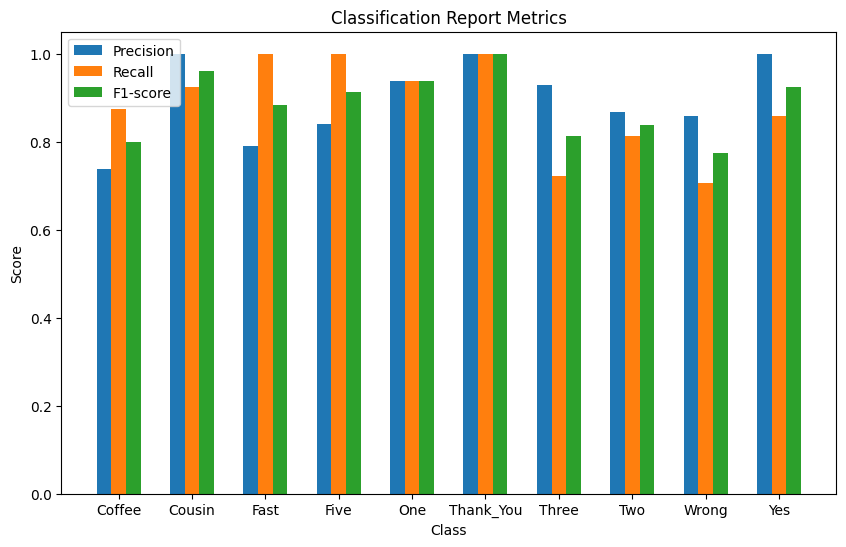

In [20]:
import pandas as pd
import numpy as np
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import precision_score, recall_score, f1_score

class EvaluateMetrics(Callback):
    def __init__(self, X_val, y_val, class_names):
        self.X_val = X_val
        self.y_val = y_val
        self.class_names = class_names

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.X_val)
        y_pred = np.argmax(y_pred, axis=1)
        y_true = np.argmax(self.y_val, axis=1)

        precision = precision_score(y_true, y_pred, average=None)
        recall = recall_score(y_true, y_pred, average=None)
        f1 = f1_score(y_true, y_pred, average=None)

        print(f"\nEpoch {epoch + 1}:")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1-score: {f1}")

        # Print detailed metrics for each class
        for i, class_name in enumerate(self.class_names):
            print(f"{class_name}: Precision={precision[i]}, Recall={recall[i]}, F1-score={f1[i]}")



# Paths for exported data, numpy arrays
DATA_PATH = os.path.join('dataset')
MRCNN_DATA_PATH = os.path.join('datasetmrcnn')

# Actions that we try to detect
actions = np.array(['Coffee', 'Cousin','Fast', 'Five', 'One','Thank_You', 'Three','Two','Wrong','Yes'])
class_names = ['Coffee', 'Cousin','Fast', 'Five', 'One','Thank_You', 'Three','Two','Wrong','Yes']

# Videos are going to be 30 frames in length
sequence_length = 60
label_map = {label: num for num, label in enumerate(actions)}

sequences, labels = [], []

# Load data from the "dataset" for training
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), f"{frame_num}.npy"))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

# Convert to numpy arrays
X = np.array(sequences)
y = to_categorical(labels).astype(int)

# Split the "dataset" data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize lists to hold MRCNN training and validation data
sequences_mrcnn_train, labels_mrcnn_train = [], []
sequences_mrcnn_val, labels_mrcnn_val = [], []

# Load data from the "datasetmrcnn" and prepare for training
for action in actions:
    sequences_mrcnn, labels_mrcnn = [], []
    dir_list = np.array(os.listdir(os.path.join(MRCNN_DATA_PATH, action))).astype(int)
    np.random.shuffle(dir_list)  # Shuffle to randomly select for train/test split
    # Calculate split index for 60/40 split
    split_index = int(len(dir_list) * 0.4)

    # Split the directories for training and validation
    train_dirs = dir_list[:split_index]
    val_dirs = dir_list[split_index:]

    
    for sequence in train_dirs:
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(MRCNN_DATA_PATH, action, str(sequence), f"{frame_num}.npy"))
            window.append(res)
        sequences_mrcnn_train.append(window)
        labels_mrcnn_train.append(label_map[action])
    
    for sequence in val_dirs:
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(MRCNN_DATA_PATH, action, str(sequence), f"{frame_num}.npy"))
            window.append(res)
        sequences_mrcnn_val.append(window)
        labels_mrcnn_val.append(label_map[action])

# Prepare MRCNN training and validation data
X_train_mrcnn = np.array(sequences_mrcnn_train)
y_train_mrcnn = to_categorical(np.array(labels_mrcnn_train), num_classes=len(actions))
X_val_mrcnn = np.array(sequences_mrcnn_val)
y_val_mrcnn = to_categorical(np.array(labels_mrcnn_val), num_classes=len(actions))

# Combine original and MRCNN training/validation data
X_train_combined = np.concatenate((X_train, X_train_mrcnn))
y_train_combined = np.concatenate((y_train, y_train_mrcnn))
X_val_combined = np.concatenate((X_val, X_val_mrcnn))
y_val_combined = np.concatenate((y_val, y_val_mrcnn))

# Updated Model architecture
model = Sequential()
model.add(LSTM(512, return_sequences=True, input_shape=(sequence_length, X.shape[2])))
model.add(BatchNormalization())  # Added BatchNormalization
model.add(Dropout(0.5))
model.add(LSTM(256, return_sequences=True))
model.add(BatchNormalization())  # Added BatchNormalization
model.add(Dropout(0.5))
model.add(LSTM(128))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(actions.shape[0], activation='softmax'))

# Compile the model with an initial learning rate
optimizer = Adam(learning_rate=0.001)  # Consider starting with a slightly higher learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Updated callbacks
log_dir = os.path.join('logs')
tensorboard_callback = TensorBoard(log_dir=log_dir)
early_stopping = EarlyStopping(monitor='val_loss', patience=20)  # Increased patience
model_checkpoint = ModelCheckpoint('best_model_10.h5', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001, verbose=1) # New Callback

# Create an instance of the custom callback
evaluate_metrics_callback = EvaluateMetrics(X_val_combined, y_val_combined, class_names)

# Train the model using the combined dataset with an updated batch size
history = model.fit(X_train_combined, y_train_combined, epochs=500, batch_size=64,  # Adjusted batch size
                    validation_data=(X_val_combined, y_val_combined),
                    callbacks=[tensorboard_callback, early_stopping, model_checkpoint, reduce_lr])

# Save the model and weights
model.save('mrcnn_lstm_model_10Cv8.h5')
model.save_weights('./mrcnn_lstm_weights_10Cv8.h5')

print("Model and weights have been saved.")

# Generate predictions
y_pred = model.predict(X_val_combined)

# Convert one-hot encoded labels back to categorical labels
y_true = np.argmax(y_val_combined, axis=1)
y_pred = np.argmax(y_pred, axis=1)

# Generate and print classification report
class_names = ['Coffee', 'Cousin','Fast', 'Five', 'One','Thank_You', 'Three','Two','Wrong','Yes']
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:")
print(report)

# Plotting the classification report
report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
precision = [report_dict[label]['precision'] for label in class_names]
recall = [report_dict[label]['recall'] for label in class_names]
f1_score = [report_dict[label]['f1-score'] for label in class_names]

x = range(len(class_names))

plt.figure(figsize=(10, 6))
plt.bar(x, precision, width=0.2, label='Precision')
plt.bar([i + 0.2 for i in x], recall, width=0.2, label='Recall')
plt.bar([i + 0.4 for i in x], f1_score, width=0.2, label='F1-score')

plt.xlabel('Class')
plt.ylabel('Score')
plt.title('Classification Report Metrics')
plt.xticks([i + 0.2 for i in x], class_names)
plt.legend()
plt.show()

Epoch 1/500
4/4 [==============================] - ETA: 0s - loss: 2.2623 - accuracy: 0.1458
Epoch 1: val_loss improved from inf to 2.26168, saving model to best_model_10.h5
4/4 [==============================] - 7s 569ms/step - loss: 2.2623 - accuracy: 0.1458 - val_loss: 2.2617 - val_accuracy: 0.1125 - lr: 0.0010
Epoch 2/500
4/4 [==============================] - ETA: 0s - loss: 1.9507 - accuracy: 0.3125
Epoch 2: val_loss improved from 2.26168 to 2.18801, saving model to best_model_10.h5
4/4 [==============================] - 0s 137ms/step - loss: 1.9507 - accuracy: 0.3125 - val_loss: 2.1880 - val_accuracy: 0.1500 - lr: 0.0010
Epoch 3/500
4/4 [==============================] - ETA: 0s - loss: 1.8180 - accuracy: 0.3750
Epoch 3: val_loss improved from 2.18801 to 2.17223, saving model to best_model_10.h5
4/4 [==============================] - 0s 136ms/step - loss: 1.8180 - accuracy: 0.3750 - val_loss: 2.1722 - val_accuracy: 0.1500 - lr: 0.0010
Epoch 4/500
4/4 [===========================

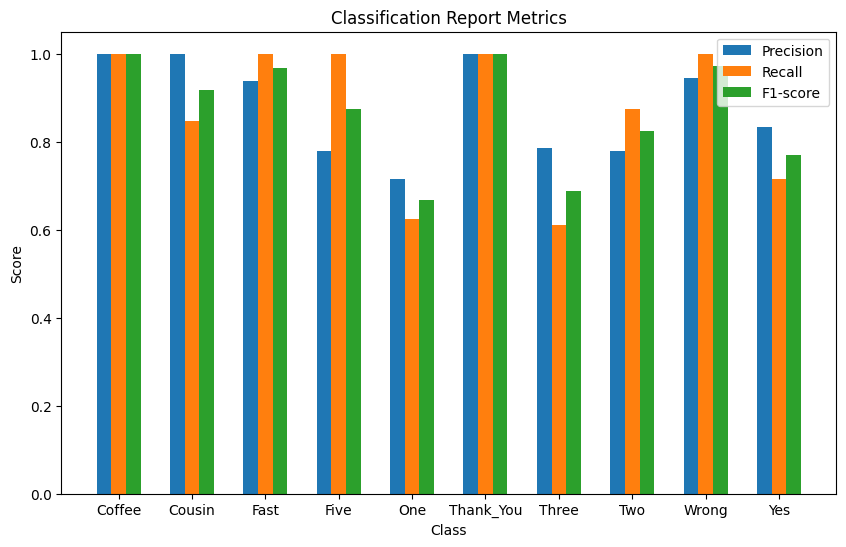

In [38]:
import pandas as pd
import numpy as np
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import precision_score, recall_score, f1_score

class EvaluateMetrics(Callback):
    def __init__(self, X_val, y_val, class_names):
        self.X_val = X_val
        self.y_val = y_val
        self.class_names = class_names
        # Initialize lists to store metrics
        self.precision_scores = []
        self.recall_scores = []
        self.f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.X_val)
        y_pred = np.argmax(y_pred, axis=1)
        y_true = np.argmax(self.y_val, axis=1)

        precision = precision_score(y_true, y_pred, average=None)
        recall = recall_score(y_true, y_pred, average=None)
        f1 = f1_score(y_true, y_pred, average=None)

        # Append metrics to lists
        self.precision_scores.append(precision)
        self.recall_scores.append(recall)
        self.f1_scores.append(f1)

        print(f"\nEpoch {epoch + 1}:")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1-score: {f1}")

        # Print detailed metrics for each class
        for i, class_name in enumerate(self.class_names):
            print(f"{class_name}: Precision={precision[i]}, Recall={recall[i]}, F1-score={f1[i]}")


# Paths for exported data, numpy arrays
DATA_PATH = os.path.join('dataset')
MRCNN_DATA_PATH = os.path.join('datasetmrcnn')

# Actions that we try to detect
actions = np.array(['Coffee', 'Cousin','Fast', 'Five', 'One','Thank_You', 'Three','Two','Wrong','Yes'])
class_names = ['Coffee', 'Cousin','Fast', 'Five', 'One','Thank_You', 'Three','Two','Wrong','Yes']

# Videos are going to be 30 frames in length
sequence_length = 60
label_map = {label: num for num, label in enumerate(actions)}

sequences, labels = [], []

# Load data from the "dataset" for training
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), f"{frame_num}.npy"))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

# Convert to numpy arrays
X = np.array(sequences)
y = to_categorical(labels).astype(int)

# Split the "dataset" data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize lists to hold MRCNN training and validation data
sequences_mrcnn_train, labels_mrcnn_train = [], []
sequences_mrcnn_val, labels_mrcnn_val = [], []

# Load data from the "datasetmrcnn" and prepare for training
for action in actions:
    sequences_mrcnn, labels_mrcnn = [], []
    dir_list = np.array(os.listdir(os.path.join(MRCNN_DATA_PATH, action))).astype(int)
    np.random.shuffle(dir_list)  # Shuffle to randomly select for train/test split
    # Calculate split index for 60/40 split
    split_index = int(len(dir_list) * 0.4)

    # Split the directories for training and validation
    train_dirs = dir_list[:split_index]
    val_dirs = dir_list[split_index:]

    
    for sequence in train_dirs:
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(MRCNN_DATA_PATH, action, str(sequence), f"{frame_num}.npy"))
            window.append(res)
        sequences_mrcnn_train.append(window)
        labels_mrcnn_train.append(label_map[action])
    
    for sequence in val_dirs:
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(MRCNN_DATA_PATH, action, str(sequence), f"{frame_num}.npy"))
            window.append(res)
        sequences_mrcnn_val.append(window)
        labels_mrcnn_val.append(label_map[action])

# Prepare MRCNN training and validation data
X_train_mrcnn = np.array(sequences_mrcnn_train)
y_train_mrcnn = to_categorical(np.array(labels_mrcnn_train), num_classes=len(actions))
X_val_mrcnn = np.array(sequences_mrcnn_val)
y_val_mrcnn = to_categorical(np.array(labels_mrcnn_val), num_classes=len(actions))

# Combine original and MRCNN training/validation data
X_train_combined = np.concatenate((X_train, X_train_mrcnn))
y_train_combined = np.concatenate((y_train, y_train_mrcnn))
X_val_combined = np.concatenate((X_val, X_val_mrcnn))
y_val_combined = np.concatenate((y_val, y_val_mrcnn))

# Updated Model architecture
model = Sequential()
model.add(LSTM(512, return_sequences=True, input_shape=(sequence_length, X.shape[2])))
model.add(BatchNormalization())  # Added BatchNormalization
model.add(Dropout(0.5))
model.add(LSTM(256, return_sequences=True))
model.add(BatchNormalization())  # Added BatchNormalization
model.add(Dropout(0.5))
model.add(LSTM(128))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(actions.shape[0], activation='softmax'))

# Compile the model with an initial learning rate
optimizer = Adam(learning_rate=0.001)  # Consider starting with a slightly higher learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Updated callbacks
log_dir = os.path.join('logs')
tensorboard_callback = TensorBoard(log_dir=log_dir)
early_stopping = EarlyStopping(monitor='val_loss', patience=20)  # Increased patience
model_checkpoint = ModelCheckpoint('best_model_10.h5', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001, verbose=1) # New Callback

# Create an instance of the custom callback
evaluate_metrics_callback = EvaluateMetrics(X_val_combined, y_val_combined, class_names)

# Train the model using the combined dataset with an updated batch size
history = model.fit(X_train_combined, y_train_combined, epochs=500, batch_size=64,  # Adjusted batch size
                    validation_data=(X_val_combined, y_val_combined),
                    callbacks=[tensorboard_callback, early_stopping, model_checkpoint, reduce_lr])

# Save the model and weights
model.save('mrcnn_lstm_model_10Cv9.h5')
model.save_weights('./mrcnn_lstm_weights_10Cv9.h5')

print("Model and weights have been saved.")

# Generate predictions
y_pred = model.predict(X_val_combined)

# Convert one-hot encoded labels back to categorical labels
y_true = np.argmax(y_val_combined, axis=1)
y_pred = np.argmax(y_pred, axis=1)

# Generate and print classification report
class_names = ['Coffee', 'Cousin','Fast', 'Five', 'One','Thank_You', 'Three','Two','Wrong','Yes']
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:")
print(report)

# Plotting the classification report
report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
precision = [report_dict[label]['precision'] for label in class_names]
recall = [report_dict[label]['recall'] for label in class_names]
f1_score = [report_dict[label]['f1-score'] for label in class_names]

x = range(len(class_names))

plt.figure(figsize=(10, 6))
plt.bar(x, precision, width=0.2, label='Precision')
plt.bar([i + 0.2 for i in x], recall, width=0.2, label='Recall')
plt.bar([i + 0.4 for i in x], f1_score, width=0.2, label='F1-score')

plt.xlabel('Class')
plt.ylabel('Score')
plt.title('Classification Report Metrics')
plt.xticks([i + 0.2 for i in x], class_names)
plt.legend()
plt.show()

Epoch 1/500
4/4 [==============================] - ETA: 0s - loss: 2.1757 - accuracy: 0.2083 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00
Epoch 1: val_loss improved from inf to 2.27515, saving model to best_model_10.h5
4/4 [==============================] - 8s 829ms/step - loss: 2.1757 - accuracy: 0.2083 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 2.2752 - val_accuracy: 0.1688 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/500
4/4 [==============================] - ETA: 0s - loss: 1.9084 - accuracy: 0.3583 - precision: 0.6667 - recall: 0.0167 - f1_score: 0.0325        
Epoch 2: val_loss did not improve from 2.27515
4/4 [==============================] - 0s 109ms/step - loss: 1.9084 - accuracy: 0.3583 - precision: 0.6667 - recall: 0.0167 - f1_score: 0.0325 - val_loss: 2.2835 - val_accuracy: 0.2000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00

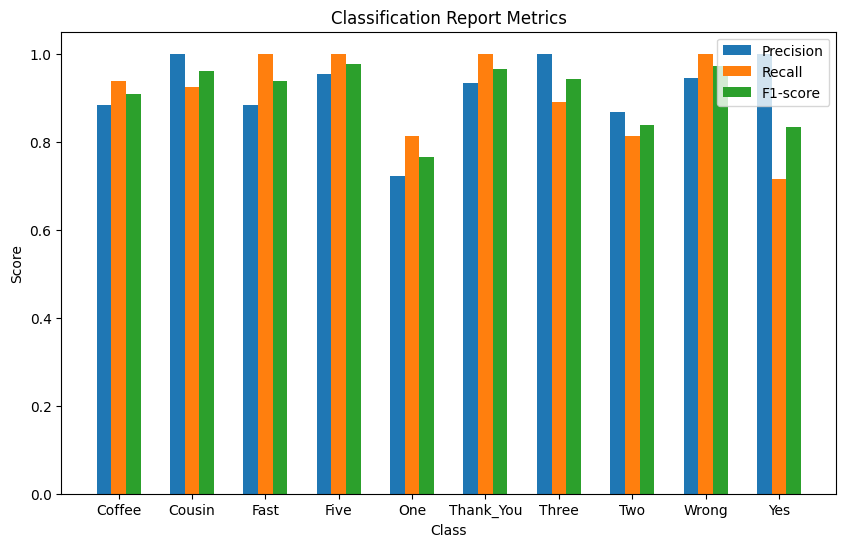

In [67]:
import pandas as pd
import numpy as np
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import Metric

class Precision(Metric):
    def __init__(self, name='precision', **kwargs):
        super(Precision, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.predicted_positives = self.add_weight(name='pp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = K.round(K.clip(y_true, 0, 1))
        y_pred = K.round(K.clip(y_pred, 0, 1))
        true_positives = K.sum(y_true * y_pred)
        predicted_positives = K.sum(y_pred)
        self.true_positives.assign_add(true_positives)
        self.predicted_positives.assign_add(predicted_positives)

    def result(self):
        return self.true_positives / (self.predicted_positives + K.epsilon())

class Recall(Metric):
    def __init__(self, name='recall', **kwargs):
        super(Recall, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.possible_positives = self.add_weight(name='pp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = K.round(K.clip(y_true, 0, 1))
        y_pred = K.round(K.clip(y_pred, 0, 1))
        true_positives = K.sum(y_true * y_pred)
        possible_positives = K.sum(y_true)
        self.true_positives.assign_add(true_positives)
        self.possible_positives.assign_add(possible_positives)

    def result(self):
        return self.true_positives / (self.possible_positives + K.epsilon())

class F1Score(Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred)
        self.recall.update_state(y_true, y_pred)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


# Paths for exported data, numpy arrays
DATA_PATH = os.path.join('dataset')
MRCNN_DATA_PATH = os.path.join('datasetmrcnn')

# Actions that we try to detect
actions = np.array(['Coffee', 'Cousin','Fast', 'Five', 'One','Thank_You', 'Three','Two','Wrong','Yes'])
class_names = ['Coffee', 'Cousin','Fast', 'Five', 'One','Thank_You', 'Three','Two','Wrong','Yes']

# Videos are going to be 30 frames in length
sequence_length = 60
label_map = {label: num for num, label in enumerate(actions)}

sequences, labels = [], []

# Load data from the "dataset" for training
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), f"{frame_num}.npy"))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

# Convert to numpy arrays
X = np.array(sequences)
y = to_categorical(labels).astype(int)

# Split the "dataset" data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize lists to hold MRCNN training and validation data
sequences_mrcnn_train, labels_mrcnn_train = [], []
sequences_mrcnn_val, labels_mrcnn_val = [], []

# Load data from the "datasetmrcnn" and prepare for training
for action in actions:
    sequences_mrcnn, labels_mrcnn = [], []
    dir_list = np.array(os.listdir(os.path.join(MRCNN_DATA_PATH, action))).astype(int)
    np.random.shuffle(dir_list)  # Shuffle to randomly select for train/test split
    # Calculate split index for 60/40 split
    split_index = int(len(dir_list) * 0.4)

    # Split the directories for training and validation
    train_dirs = dir_list[:split_index]
    val_dirs = dir_list[split_index:]

    
    for sequence in train_dirs:
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(MRCNN_DATA_PATH, action, str(sequence), f"{frame_num}.npy"))
            window.append(res)
        sequences_mrcnn_train.append(window)
        labels_mrcnn_train.append(label_map[action])
    
    for sequence in val_dirs:
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(MRCNN_DATA_PATH, action, str(sequence), f"{frame_num}.npy"))
            window.append(res)
        sequences_mrcnn_val.append(window)
        labels_mrcnn_val.append(label_map[action])

# Prepare MRCNN training and validation data
X_train_mrcnn = np.array(sequences_mrcnn_train)
y_train_mrcnn = to_categorical(np.array(labels_mrcnn_train), num_classes=len(actions))
X_val_mrcnn = np.array(sequences_mrcnn_val)
y_val_mrcnn = to_categorical(np.array(labels_mrcnn_val), num_classes=len(actions))

# Combine original and MRCNN training/validation data
X_train_combined = np.concatenate((X_train, X_train_mrcnn))
y_train_combined = np.concatenate((y_train, y_train_mrcnn))
X_val_combined = np.concatenate((X_val, X_val_mrcnn))
y_val_combined = np.concatenate((y_val, y_val_mrcnn))

# Updated Model architecture
model = Sequential()
model.add(LSTM(512, return_sequences=True, input_shape=(sequence_length, X.shape[2])))
model.add(BatchNormalization())  # Added BatchNormalization
model.add(Dropout(0.5))
model.add(LSTM(256, return_sequences=True))
model.add(BatchNormalization())  # Added BatchNormalization
model.add(Dropout(0.5))
model.add(LSTM(128))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(actions.shape[0], activation='softmax'))

# Compile the model with an initial learning rate
optimizer = Adam(learning_rate=0.001)  # Consider starting with a slightly higher learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy',  Precision(), Recall(), F1Score()])

# Updated callbacks
log_dir = os.path.join('logs')
tensorboard_callback = TensorBoard(log_dir=log_dir)
early_stopping = EarlyStopping(monitor='val_loss', patience=20)  # Increased patience
model_checkpoint = ModelCheckpoint('best_model_10.h5', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001, verbose=1) # New Callback

# Create an instance of the custom callback
evaluate_metrics_callback = EvaluateMetrics(X_val_combined, y_val_combined, class_names)

# Train the model using the combined dataset with an updated batch size
history = model.fit(X_train_combined, y_train_combined, epochs=500, batch_size=64,  # Adjusted batch size
                    validation_data=(X_val_combined, y_val_combined),
                    callbacks=[tensorboard_callback, early_stopping, model_checkpoint, reduce_lr])

# Save the model and weights
model.save('mrcnn_lstm_model_10Cv12.h5')
model.save_weights('./mrcnn_lstm_weights_10Cv12.h5')

print("Model and weights have been saved.")

# Generate predictions
y_pred = model.predict(X_val_combined)

# Convert one-hot encoded labels back to categorical labels
y_true = np.argmax(y_val_combined, axis=1)
y_pred = np.argmax(y_pred, axis=1)

# Generate and print classification report
class_names = ['Coffee', 'Cousin','Fast', 'Five', 'One','Thank_You', 'Three','Two','Wrong','Yes']
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:")
print(report)

# Plotting the classification report
report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
precision = [report_dict[label]['precision'] for label in class_names]
recall = [report_dict[label]['recall'] for label in class_names]
f1_score = [report_dict[label]['f1-score'] for label in class_names]

x = range(len(class_names))

plt.figure(figsize=(10, 6))
plt.bar(x, precision, width=0.2, label='Precision')
plt.bar([i + 0.2 for i in x], recall, width=0.2, label='Recall')
plt.bar([i + 0.4 for i in x], f1_score, width=0.2, label='F1-score')

plt.xlabel('Class')
plt.ylabel('Score')
plt.title('Classification Report Metrics')
plt.xticks([i + 0.2 for i in x], class_names)
plt.legend()
plt.show()

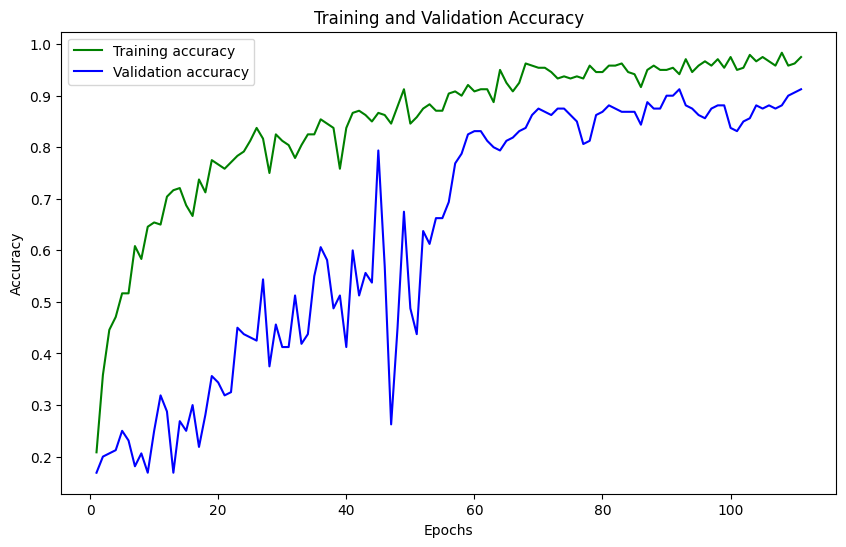

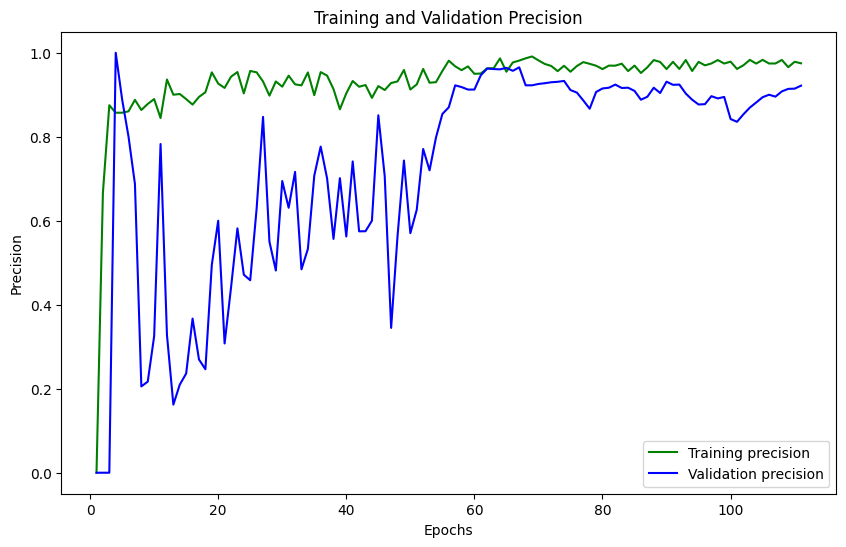

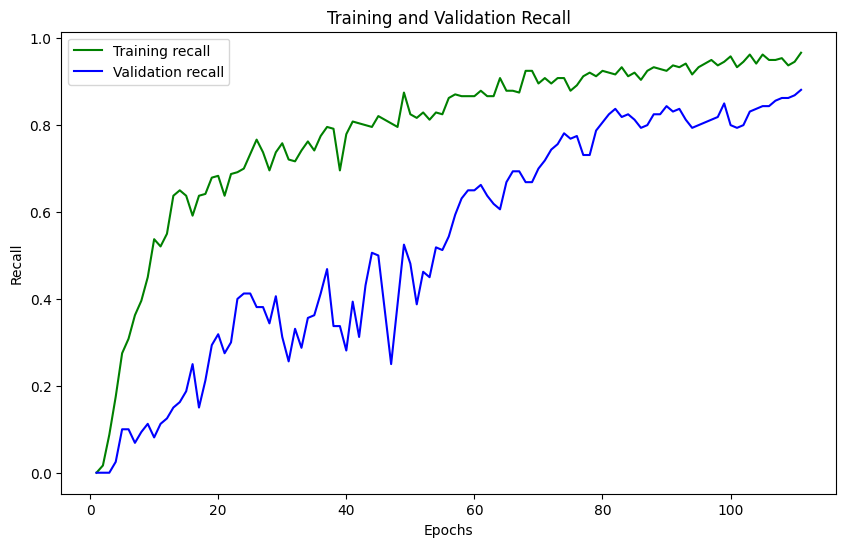

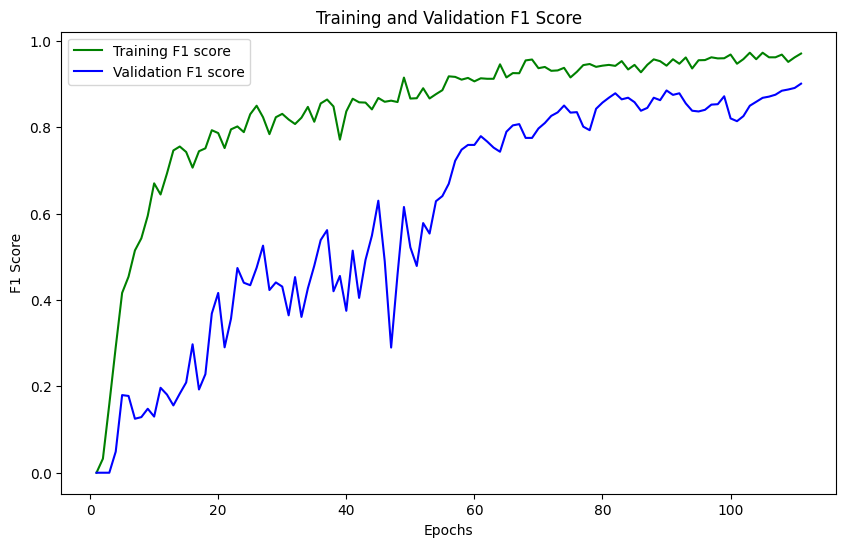

In [70]:
import matplotlib.pyplot as plt

# Assuming 'history' is the object returned by model.fit()
# Extracting metrics from the history object
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Assuming Precision, Recall, and F1Score are custom metrics you've defined and used during training
# If these metrics are not directly available in the history object, you might need to adjust the code
# to access them correctly. For simplicity, let's assume they are available.
precision = history.history['precision']
val_precision = history.history['val_precision']

recall = history.history['recall']
val_recall = history.history['val_recall']

f1_score = history.history['f1_score']
val_f1_score = history.history['val_f1_score']

# Creating the epoch range
epochs = range(1, len(accuracy) + 1)

# Plotting accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracy, 'g', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting precision
plt.figure(figsize=(10, 6))
plt.plot(epochs, precision, 'g', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Plotting recall
plt.figure(figsize=(10, 6))
plt.plot(epochs, recall, 'g', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

# Plotting F1 score
plt.figure(figsize=(10, 6))
plt.plot(epochs, f1_score, 'g', label='Training F1 score')
plt.plot(epochs, val_f1_score, 'b', label='Validation F1 score')
plt.title('Training and Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()


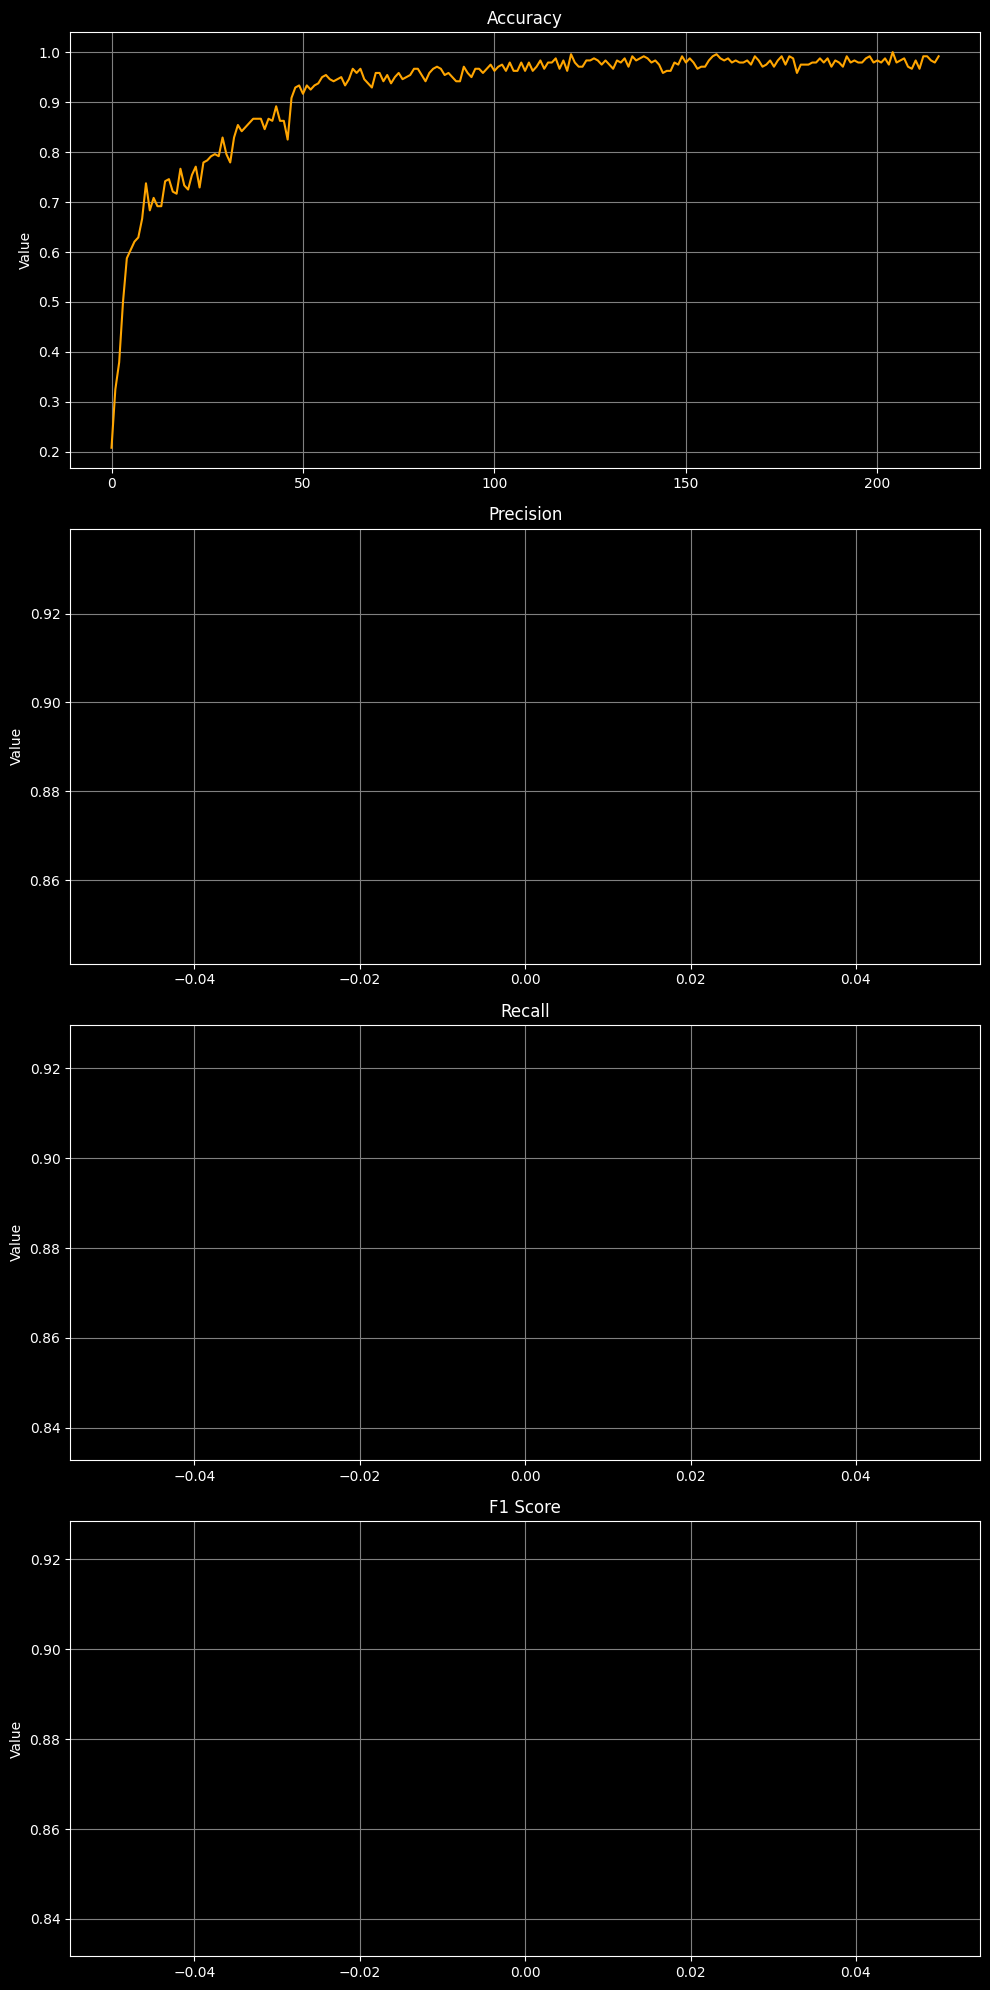

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming accuracy_mean, precision_mean, recall_mean, and f1 are defined
accuracy_mean = np.mean(accuracy) if isinstance(accuracy, np.ndarray) else accuracy
precision_mean = np.mean(precision) if isinstance(precision, np.ndarray) else precision
recall_mean = np.mean(recall) if isinstance(recall, np.ndarray) else recall

# Metrics to plot
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy_mean, precision_mean, recall_mean, f1]

# Plotting each metric in a separate graph with dark mode settings
fig, axs = plt.subplots(4, figsize=(10, 20))

# Set dark mode background for the figure and axes
fig.patch.set_facecolor('black') # Set figure background color
for ax in axs:
    ax.set_facecolor('black') # Set axes background color

for i, metric in enumerate(metrics):
    axs[i].plot(values[i], marker='', color='orange') # Set line color to orange
    axs[i].set_title(metric, color='white') # Set title text color to white
    axs[i].set_ylabel('Value', color='white') # Set y-axis label color to white
    axs[i].tick_params(axis='x', colors='white') # Set x-axis tick color to white
    axs[i].tick_params(axis='y', colors='white') # Set y-axis tick color to white
    axs[i].spines['bottom'].set_color('white') # Set x-axis spine color to white
    axs[i].spines['left'].set_color('white') # Set y-axis spine color to white
    axs[i].spines['top'].set_color('white') # Set top spine color to white
    axs[i].spines['right'].set_color('white') # Set right spine color to white
    axs[i].grid(True, color='gray') # Set grid color to gray

plt.tight_layout()
plt.show()
